## Clasificador de género usando TensorFlow y Keras 

**En este proyecto vamos a crear un clasificador de género basado en Convolutional Neural Network (CNN) utilizando TensorFlow y Keras.**

El código, lo vamos a hacer con TensorFlow pero dentro de TensorFlow tenemos posibilidad de llamar la librería Keras. Así que vamos a usar el Keras pero dentro del TensorFlow. 

Para la clasificación de género se usa el conjunto de datos UTKFace de la plataforma KAGGLE (https://www.kaggle.com/jangedoo/utkface-new). El dataset consta de más de 20.000 imágenes de rostros con anotaciones de edad, género y etnia, pero para la realización de este proyecto se han elegido aleatoriamente 1200 imágenes que pertenecen a hombres y mujeres. 

In [2]:
# Importamos todas las librerías

# lo usamos para movernos en carpetas dentro de nuestro sistema operativo
import os 

# especializada en el manejo y análisis de estructuras de datos
import pandas as pd

# introduce los vectores y las matrices en Python
import numpy as np

# para generar fácilmente elegantes gráficos
import seaborn as sns

# para generar gráficos
%matplotlib inline
from matplotlib import pyplot as plt

# para añadir bordes a las imágenes y para aplicar efectos que crean imágenes inversas
from PIL import Image, ImageOps

# permite dividir un dataset en entrenamiento y validación 
from sklearn.model_selection import train_test_split

# para preprocesar las imágenes que le vamos a dar para entrenar el modelo
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# el optimizador para entrenar el algoritmo
from keras import optimizers

# nos permite hacer redes neuronales secuenciales para tener cada una de las capas en órden
from tensorflow.python.keras.models import Sequential

# Flatten - convierte os elementos de la matriz de imagenes de entrada en un array plano
# con Dense añadimos una capa oculta (hidden layer) de la red neuronal
# Dropout - hacemos la función de regularización
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation 

# son nuestras capas en las cuales vamos a estar haciendo convoluciones y max pooling
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D


### Cargamos los datos

Vamos a extraer las imagenes de la carpeta "Imagenes" utilizando el bucle for. 
La función **os.listdir** nos devuelve una lista que contiene los nombres de las imagenes. Dentro de esta función indicamos 'path' que obtenemos introduciendo **os.getcwd()**.

Estas imágenes pertenecen a hombres y mujeres con edades que van de 0 a 116. Cada imagen tiene etiquetas que muestran la edad y el sexo correspondientes (Por ejemplo: '15_1_0_20170109213511851.jpg.chip.jpg', donde 15 es la edad y 1 es el sexo). Masculino viene dado por 0 y Femenino por 1. Vamos a separar el género del nombre de la imagen utilizando la función split().

In [3]:
images = []
genders = []
for i in os.listdir("/home/jovyan/work/Fotos/"):
    split = i.split('_')
    genders.append(int(split[1]))
    images.append(Image.open('/home/jovyan/work/Fotos/' + i))

In [4]:
# Tomamos solo las imágenes y los datos de género del conjunto de datos cargado.
images = pd.Series(list(images), name = 'Images')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, genders], axis=1)
df

,Images,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
...,...,...
1195,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
1196,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1197,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
1198,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1


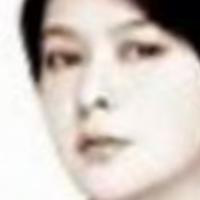

1


In [5]:
# Visualizamos una imágen del sexo masculino 
display(df['Images'][327])
print(df['Genders'][0])

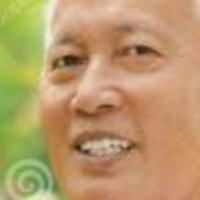

0


In [6]:
# Visualizamos una imágen del sexo femenino
display(df['Images'][3])
print(df['Genders'][3])

Como podemos ver en el resultado anterior, las imágenes que usaremos para entrenar nuestro modelo contienen solo caras.

### Visualización y preparación de los datos

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Genders', ylabel='count'>

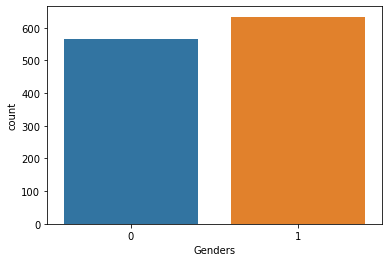

In [7]:
# Visualizamos la cantidad de hombres y mujeres
sns.countplot(df['Genders'])

Utilizando el bucle for, vamos a redimensionar nuestras imágenes. Con un ancho y una altura de 200 píxeles.
La función **Image.resize(size, resample)** de la librería PIL devuelve una copia redimensionada de las imágenes. 
Donde **size** es el tamaño solicitado en píxeles (ancho, alto). Y **resample** un filtro de remuestreo opcional, en nuestro caso es **Image.ANTIALIAS**: un filtro de reducción de resolución de alta calidad.

In [8]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    gen = [int(df['Genders'].iloc[i])]
    y.append(gen)
x = np.array(x)

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Train Test Split

In [9]:
# Ejecutamos la división con train 80% y test 20%.
y_gender = df['Genders']

x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size = 0.2, stratify = y_gender)

In [10]:
print('Training data shape : ', x_train_gender.shape, y_train_gender.shape)
print('Testing data shape : ', x_test_gender.shape, y_test_gender.shape)

Training data shape :  (960, 200, 200, 3) (960,)
Testing data shape :  (240, 200, 200, 3) (240,)


A partir del resultado anterior se puede ver que los datos de entrenamiento tienen una forma de 960 x 200 x 200, ya que hay 960 muestras de entrenamiento cada una con una dimensión de 200x200. De manera similar, los datos de prueba tienen una forma de 240 x 200 x 200 ya que hay 240 muestras de prueba. 

### Creación de modelos

Para crear nuestro modelo de CNN debemos seguir los siguientes pasos:
1. Sequential() – estamos diciendo que la red que vamos a generar es secuencial, es decir, que son varias capas apiladas entre ellas.
2.	Creamos nuestra primera capa: Conv2D implementa la convolución en dos dimensiones de la imagen de entrada que va a tener el número de filtros 32, el tamaño de nuestro filtro (3, 3), input_shape – las imágenes van a tener una cierta altura y cierta longitud con profundidad 3. 

**activation = ‘relu’**

Cuando procesamos una imagen, cada capa de convolución debe capturar algún patrón en la imagen y pasarla en la siguiente capa de convolución. Los valores negativos no son importantes en el procesamiento de imágenes y, por lo tanto, se establecen en 0. Pero los valores positivos después de la convolución deben pasar a la siguiente capa. Es por eso que Relu se está utilizando como una función de activación. Si utilizamos sigmoide o tanh, la información se pierde ya que ambas funciones modificarán las entradas a un rango muy cerrado.


3.	Añadimos una capa de pooling – después de la primera capa de convolucion vamos a tener una capa MaxPooling2D que reduce el tamaño de las imágenes y el filtro va a tener tamaño (2, 2) píxeles. Esta operación mejora el rendimiento y afecta poco a la precisión.

4.	Después de pooling añadimos nuestra siguiente capa convolucional. El parámetro input_shape no lo ponemos aquí. Se pone normalmente en la primera capa la cual recibe las imágenes.
5. Añadimos otra capa de max pooling
6. Añadimos nuestra siguiente capa convolucional con el número de filtros 128. 
7. Añadimos la última capa de max pooling.


In [11]:
# 1
genmodel = Sequential()
# 2
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
# 3 
genmodel.add(MaxPooling2D((2,2)))
# 4
genmodel.add(Conv2D(64, (3,3), activation='relu'))
# 5 
genmodel.add(MaxPooling2D((2,2)))
# 6 
genmodel.add(Conv2D(128, (3,3), activation='relu'))
# 7
genmodel.add(MaxPooling2D((2,2)))

Ahora empezamos nuestra clasificación:
1. Flatten() lo que vamos a hacer es que esta imagen ahora es muy profunda pero muy pequeña, la vamos a hacer plana.  Es decir, vamos a tener solo una dimensión que contiene toda la información de nuestra red neuronal. 

2. Dense(64, activation='relu') – va a tener 64 neuronas. Después de aplanar nuestra información vamos a mandarlo a una capa normal, esto simplemente añade una capa donde van a estar todas las neuronas conectadas con las neuronas de la capa anterior.

3. Dropout(0.5) – se conoce como regularización y su función es prevenir el sobreajuste otorgando a cada neurona una probabilidad del 50% de no activarse durante la fase de entrenamiento.

4. Dense(1, activation='sigmoid') – es la capa de salida que tiene. Como creamos el modelo para un problema de clasificación binaria, tenemos que hacer que la salida en la última capa densa sea 1 y usar una función de activación sigmoidea solo para la última capa. 

La función de activación sigmoid o función logística. Es la misma función utilizada en el algoritmo de clasificación de regresión logística. La función toma cualquier valor real como valores de entrada y de salida en el rango de 0 a 1. Cuanto mayor sea la entrada (más positiva), más cerca estará el valor de salida a 1, mientras que cuanto más pequeña sea la entrada (más negativa), más cerca estará la salida a 0.


In [12]:
# 1
genmodel.add(Flatten())
# 2
genmodel.add(Dense(64, activation='relu'))
# 3 
genmodel.add(Dropout(0.5))
# 4
genmodel.add(Dense(1, activation='sigmoid'))


Una vez que tengamos nuestro modelo definido, podemos configurar cómo será su proceso de aprendizaje con el método **compile( )**, con el que podemos especificar algunas propiedades a través de argumentos del método:
1. El primero de estos argumentos es la función de loss que usaremos para evaluar el grado de error entre salidas calculadas y las salidas deseadas de los datos de entrenamiento.  
2. Por otro lado, se especifica un optimizador que, como veremos, es la manera que tenemos de especificar el algoritmo de optimitzación que permite a la red neuronal calcular los pesos de los parámetros a partir de los datos de entrada y de la función de loss definida. 
3. Y finalmente debemos indicar la métrica que usaremos para monitorizar el proceso de aprendizaje (y prueba) de nuestra red neuronal. En este primer ejemplo solo tendremos en cuenta la accuracy (fracción de imágenes que son correctamente clasificadas). 


En nuestro caso especificamos los siguientes argumentos en el método compile( ) para probarlo en nuestro modelo:
- la función de loss "binary_crossentropy": es para clasificación binaria de múltiples etiquetas (las etiquetas son independientes).
- la función para calcular los gradientes llamada adam con 'lr = 0.0001' – es el learning rate y es que tan grande van a ser los ajustes que hacen nuestra red neuronal para acercarse a una solución óptima. 
- métrica es accuracy, con la que evaluaremos el porcentaje de aciertos averiguando dónde el modelo predice la etiqueta correcta.

In [13]:
genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

Antes del entrenamiento del modelo, podemos mirar la arquitectura y los parámetros de la red usando genmodel.summary() que incluye:

    Nombre y tipo de todas las capas del modelo.
    Forma de salida para cada capa.
    Número de parámetros de peso de cada capa.
    

In [14]:
genmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

Vemos que se requieren 4.426.945 parámetros (columna Param #), que corresponden a los 896 parámetros para la primera capa, 18.496 para la segunda, 73.856 corresponden a la tercera capa, 4.333.632 a la cuarta y 65 a la quinta.

### Entrenamiento del modelo

1. Para poder empezar el entrenamiento, tenemos que hacer el procesamiento de nuestras imágenes para dárselas a la red neuronal. 

Dentro de **ImageDataGenerator** especificamos los parámetros: 
-  rescale = 1./255. – cada uno de nuestros píxeles tiene un rango de 0 a 255 y al hacer este reescalado vamos a decir que en vez de 1./255. todos nuestros valores de píxeles estén de 0 a 1. Esto es para hacer más eficiente nuestro entrenamiento. 
- horizontal_flip = True – va a coger una imagen y la va a invertir para que aprenda también a distingir la direccionalidad nuestra red neuronal.
- width shift range, height shift range: cambia de orientación los pixeles de algunas partes de la imagen. Es un número de coma flotante entre 0.0 y 1.0.

2. Para la validación solo ponemos un parámetro 'rescale'. Lo hacemos asi, porque para la validación queremos dar las imágenes tal cual son.

3. Ahora vamos a usar la variable entrenamiento_datagen para entrar en x_train_gender donde tenemos datos de entrenamiento y va a procesar todas la imágenes.
Dentro especificamos el parámetro **batch_size** – es el número de imágenes que vamos a procesar en cada uno de los pasos.

4. Haremos lo mismo para test de validación. 

5. Entrenamos nuestro modelo. Para ello utilizamos el método fit( ) y indicamos:

          - datos de entrenamiento.
          - epochs = 50 que es el número de veces que vamos a entrenar el modelo. Una época significa realizar una iteración de entrenamiento utilizando los datos proporcionados, todos los datos proporcionados serán utilizados una vez por nuestro modelo. 
          - shuffle = True es el parámetro que cuando se establece en true entrena el modelo tomando los datos proporcionados de manera aleatoria. 
          - datos de validación.


In [15]:
# 1 
entrenamiento_datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)
# 2
test_datagen = ImageDataGenerator(rescale=1./255)
# 3 
train2 = entrenamiento_datagen.flow(x_train_gender, y_train_gender, batch_size=64)
# 4
test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)
# 5
history2 = genmodel.fit(train2, epochs=75, shuffle=True, validation_data=test2)

Epoch 1/75
15/15 [==============================] - 291s 17s/step - loss: 0.6957 - accuracy: 0.4961 - val_loss: 0.6776 - val_accuracy: 0.5458
Epoch 2/75
15/15 [==============================] - 110s 7s/step - loss: 0.6781 - accuracy: 0.5818 - val_loss: 0.6651 - val_accuracy: 0.6125
Epoch 3/75
15/15 [==============================] - 166s 11s/step - loss: 0.6751 - accuracy: 0.5720 - val_loss: 0.6497 - val_accuracy: 0.5917
Epoch 4/75
15/15 [==============================] - 109s 7s/step - loss: 0.6614 - accuracy: 0.6232 - val_loss: 0.6418 - val_accuracy: 0.6083
Epoch 5/75
15/15 [==============================] - 91s 6s/step - loss: 0.6412 - accuracy: 0.6575 - val_loss: 0.6244 - val_accuracy: 0.6458
Epoch 6/75
15/15 [==============================] - 60s 4s/step - loss: 0.6387 - accuracy: 0.6526 - val_loss: 0.6227 - val_accuracy: 0.6000
Epoch 7/75
15/15 [==============================] - 56s 4s/step - loss: 0.6252 - accuracy: 0.6765 - val_loss: 0.6224 - val_accuracy: 0.6375
Epoch 8/75
15/

La ejecución del código anterior nos proporciona la precisión y el valor de pérdida para cada época. Podemos ver que nos va indicando para cada epoch cuánto tiempo ha tardado (información muy útil para estimar cuanto va a tardar aproximadamente realizar todas las epochs) y los valores de 4 métricas por cada epoch: loss, accuracy, validation_loss y validation_accuracy.

In [16]:
# Evaluate the model on test set
score = genmodel.evaluate(x_train_gender, y_train_gender, verbose=0)
# Print test accuracy
print('\n', 'Train accuracy:', round(score[1], 3))
print('Train loss:', round(score[0], 3))


 Train accuracy: 0.83
Train loss: 33.038


In [17]:
# Evaluate the model on test set
score = genmodel.evaluate(x_test_gender, y_test_gender, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', round(score[1], 3))
print('Test loss:', round(score[0], 3))


 Test accuracy: 0.754
Test loss: 52.454


Que nos está indicando que el modelo que hemos creado en este sobre los datos que nunca ha visto anteriormente, clasifica el 75% de ellos correctamente. No estamos obteniendo resultados tan buenos. La test accuracy es un poco más baja que la train accuracy. La pérdida de test accuracy también es un poco menos.

La test accuracy es más baja que train accuracy lo que nos indica que se está produciendo el efecto del sobreentrenamiento (Overfitting) a partir de un número de epochs. 

Grafiquemos las pérdidas entre los datos de entrenamiento y validación:

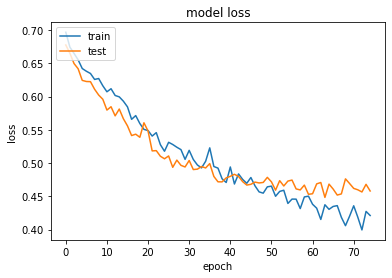

In [18]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

La curva anterior muestra que nuestro modelo no tiene overfitting.

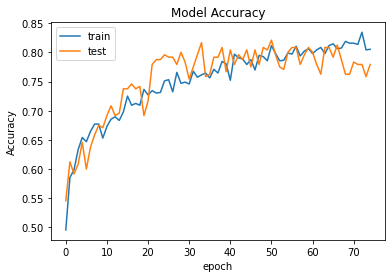

In [19]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Modelo de evaluación 

In [20]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

Gender: male


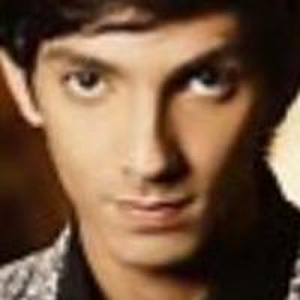

In [21]:
process_and_predict('/home/jovyan/work/Imagenes/18_0_3_20170117135605224.jpg.chip.jpg')

Gender: male


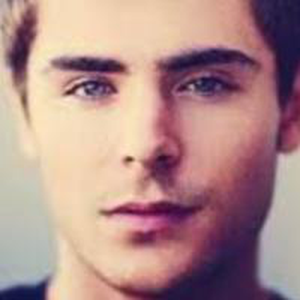

In [22]:
process_and_predict('/home/jovyan/work/Imagenes/16_0_0_20170120133327900.jpg.chip.jpg')

Gender: female


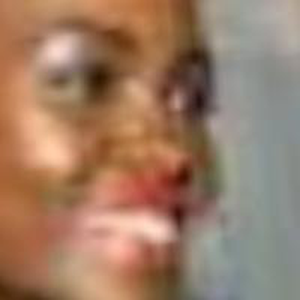

In [23]:
process_and_predict('/home/jovyan/work/Imagenes/26_1_1_20170117201147190.jpg.chip.jpg')

Gender: male


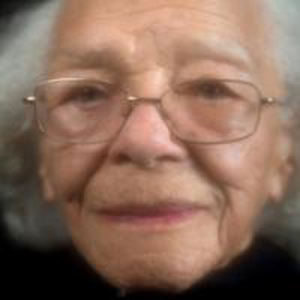

In [24]:
process_and_predict('/home/jovyan/work/Imagenes/100_1_0_20170112215032192.jpg.chip.jpg')

Gender: male


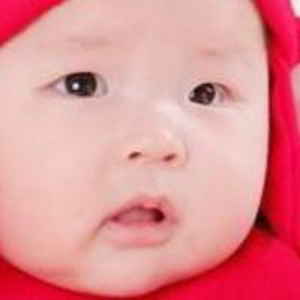

In [25]:
process_and_predict('/home/jovyan/work/Imagenes/1_0_2_20161219203954396.jpg.chip.jpg')

In [26]:
# Guardamos el modelo

genmodel.save_weights('full_model_weights.h5')
genmodel.save('model.h5')

Gender: male


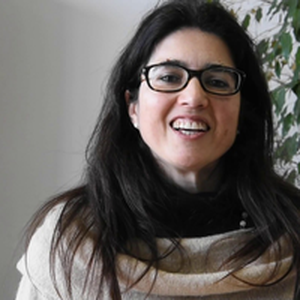

In [27]:
process_and_predict('/home/jovyan/work/1_1_0_20170110412907649.jpg.chip.jpg')

Gender: male


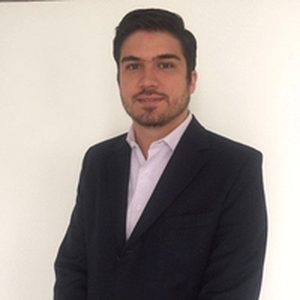

In [28]:
process_and_predict('/home/jovyan/work/1_0_0_20170110912907649.jpg.chip.jpg')

Gender: male


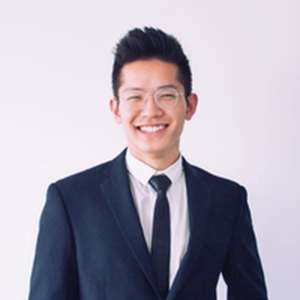

In [29]:
process_and_predict('/home/jovyan/work/1_0_0_20170114412907649.jpg.chip.jpg')

Gender: male


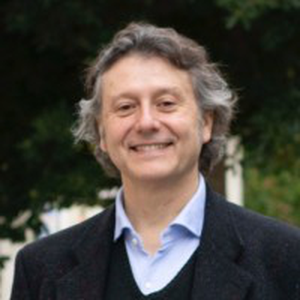

In [30]:
process_and_predict('/home/jovyan/work/1_0_0_20170117712907649.jpg.chip.jpg')

Gender: male


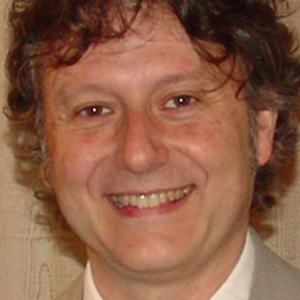

In [31]:
process_and_predict('/home/jovyan/work/1_0_0_20170118812907649.jpg.chip.jpg')

Gender: male


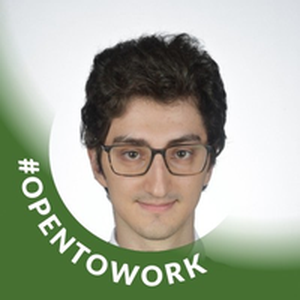

In [32]:
process_and_predict('/home/jovyan/work/21_0_0_20170110212907649.jpg.chip.jpg')

Gender: male


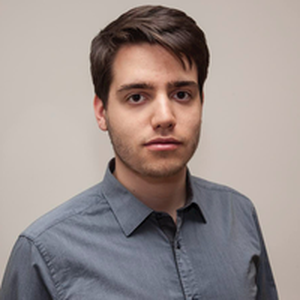

In [33]:
process_and_predict('/home/jovyan/work/22_0_0_20170110212907649.jpg.chip.jpg')

Gender: female


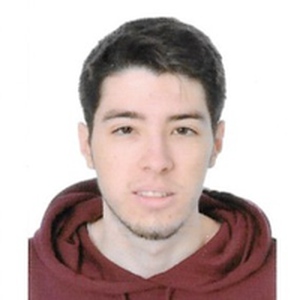

In [34]:
process_and_predict('/home/jovyan/work/23_0_0_20170110212907649.jpg.chip.jpg')

Gender: male


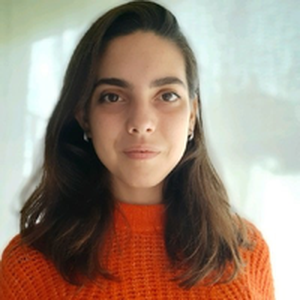

In [35]:
process_and_predict('/home/jovyan/work/24_1_0_20170110412907649.jpg.chip.jpg')

Gender: male


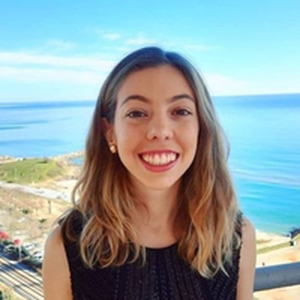

In [36]:
process_and_predict('/home/jovyan/work/24_1_0_20170110212907649.jpg.chip.jpg')

Gender: female


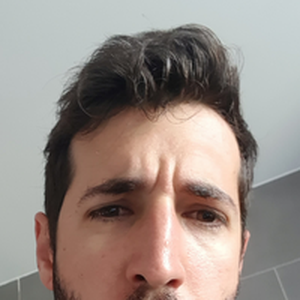

In [37]:
process_and_predict('/home/jovyan/work/28_0_0_20170110212907649.jpg.chip.jpg')

Gender: female


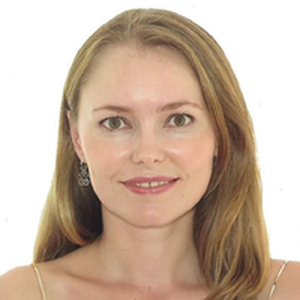

In [38]:
process_and_predict('/home/jovyan/work/35_1_0_20170110212907649.jpg.chip.jpg')

Gender: male


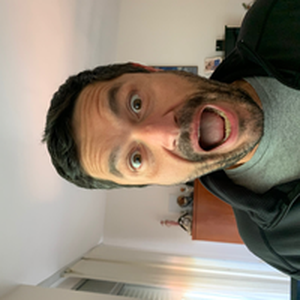

In [39]:
process_and_predict('/home/jovyan/work/45_0_0_20170110212907649.jpg.chip.jpg')

Gender: female


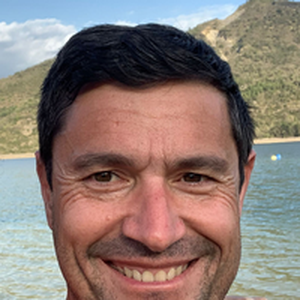

In [40]:
process_and_predict('/home/jovyan/work/45_0_0_20170110312907649.jpg.chip.jpg')

Gender: male


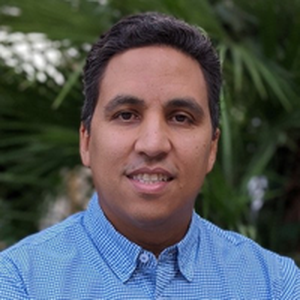

In [41]:
process_and_predict('/home/jovyan/work/47_0_0_20170110212907649.jpg.chip.jpg')